#Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import cv2
import random
import os
import glob
import albumentations as A
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.layers import Conv2D,SeparableConv2D,Input, Flatten, MaxPooling2D, Dense, Dropout , BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
!pip install google-colab
import google.colab.drive as drive

In [ ]:
drive.mount('/content/drive')
!unzip "/content/drive/My Drive/Archive.zip"

#Data Generator

In [ ]:
# Load images from the train directory
train_generator = train_datagen.flow_from_directory(
    'train',
    shuffle=True,
    target_size=(224, 224),  # adjust to the input size of your model
    batch_size=32,  # adjust based on your requirements
    class_mode='binary'  # or 'categorical' for multi-class problems
)

Found 5216 images belonging to 2 classes.


In [ ]:
# Initialize the ImageDataGenerator for validation and test data (without data augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from the validation directory
val_generator = val_test_datagen.flow_from_directory(
    'val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Load images from the test directory
test_generator = val_test_datagen.flow_from_directory(
    'test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#Build CNN Model

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )

    return block

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(224, 224, 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [ ]:
model =  build_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 sequential (Sequential)     (None, 56, 56, 32)        2160      
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 64)        7392      
                                                                 
 sequential_2 (Sequential)   (None, 14, 14, 128)       27072     
                                                      

In [ ]:
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

opt = Adam(learning_rate=0.001)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy',
              metrics=METRICS,
              optimizer=opt,
              run_eagerly=True)


In [ ]:
batch_size = 32
nb_epochs = 20

#Correcting Data imbalance using Class weight
Due a imbalanced class we shoud compensate defining the class_weight.

In [ ]:
class_weight ={0:1.95, 1:0.67}

#Train the Model

In [ ]:
%%time
# Fit the model
history = model.fit(train_generator,
                    epochs=nb_epochs,
                    steps_per_epoch=len(train_data)/ batch_size,
                    validation_data=val_generator,
                    callbacks=[es, chkpt],
                    class_weight=class_weight)

Epoch 1/20
163/163 [==============================] - 126s 707ms/step - loss: 0.2624 - accuracy: 0.7824 - precision: 0.9338 - recall: 0.7610 - val_loss: 0.9649 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/20
163/163 [==============================] - 123s 754ms/step - loss: 0.1688 - accuracy: 0.8763 - precision: 0.9609 - recall: 0.8689 - val_loss: 2.1065 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/20
163/163 [==============================] - 117s 716ms/step - loss: 0.1595 - accuracy: 0.8898 - precision: 0.9583 - recall: 0.8903 - val_loss: 3.1121 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/20
163/163 [==============================] - 118s 723ms/step - loss: 0.1458 - accuracy: 0.8980 - precision: 0.9650 - recall: 0.8952 - val_loss: 3.4380 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/20
163/163 [==============================] - 118s 720ms/step - loss: 0.1328 - a

# Visualizing model performance
Let's plot the model accuracy and loss for the training and the validating set. These plots show the accuracy and loss values for the training.



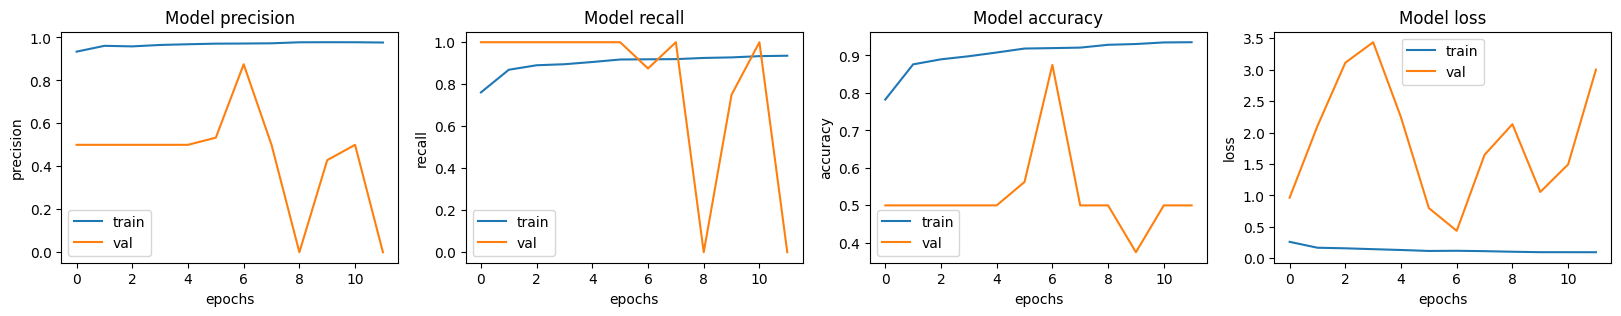

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#Predict and evaluate results


In [ ]:
loss, acc, prec, rec = model.evaluate(test_generator)

20/20 [==============================] - 5s 247ms/step - loss: 3.3781 - accuracy: 0.4167 - precision: 0.9333 - recall: 0.0718


#Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

pred=model.predict(test_generator)
print(confusion_matrix(test_generator.classes,pred>0.5))

pd.DataFrame(classification_report(test_generator.classes ,pred >0.5,output_dict=True))

20/20 [==============================] - 9s 408ms/step
[[220  14]
 [374  16]]


,0,1,accuracy,macro avg,weighted avg
precision,0.370370,0.533333,0.378205,0.451852,0.472222
recall,0.940171,0.041026,0.378205,0.490598,0.378205
f1-score,0.531401,0.076190,0.378205,0.303796,0.246894
support,234.000000,390.000000,0.378205,624.000000,624.000000
